In [1]:
import numpy as np
import pandas as pd
import scipy.signal
import scipy.io
import os
import glob
#import json

In [2]:
#Global variables
sampling_rate=512;
bin_size=10;

#Modify the Path here acording to the download location
data_path="/home/sapta/Documents/"

In [3]:
def amp_en(alldata, bin_size=bin_size):
    number_of_datapoints, number_of_channels = alldata.shape
    
    # Filtering all the channels
    Aamplitude = np.empty((number_of_datapoints, number_of_channels))
    for i in range(number_of_channels):
        Aamplitude[:, i] = np.abs(scipy.signal.hilbert(alldata[:, i]))
    
    en = np.empty(number_of_datapoints)
    
    # Calculating Entropies across channels
    for t in range(number_of_datapoints):
        hist, bin_edges = np.histogram(Aamplitude[t, :], bins=np.arange(min(Aamplitude[t, :]), max(Aamplitude[t, :]) + bin_size, bin_size))
        pmf = hist / np.sum(hist)
        pmf = pmf[pmf > 0]
        en[t] = -np.sum(pmf * np.log2(pmf))
    
    return en

AEs with time

In [4]:
output_events={'fileID':[],'pat_id':[],'sez_id':[],'sez_len':[],'elec_no':[],'AE':[]}

for patid in range(1,17):
    mat_files = glob.glob(os.path.join(data_path+"ID"+str(patid), '*.mat'))
    no_of_seizures = len(mat_files)
    #print("No of seizures: ", no_of_seizures)
    #Slength=[];no_of_electrodes=[];

    for i in range(1,no_of_seizures+1):
        filename = os.path.join(data_path, "ID"+str(patid)+"/Sz"+str(i)+".mat")
        mat=scipy.io.loadmat(filename)
        data=np.array(mat.get('EEG'))

        #Sampling rate is 512Hz and each seizure preceded and succeeded by a 3 mins long segment
        sez_length=(np.shape(data)[0]/sampling_rate) - (2*3*60) #in seconds
        no_elec=np.shape(data)[1]
        
        # Slength.append(sez_length) #in seconds
        # no_of_electrodes.append(no_elec)
        
        output_events['fileID'].append("p"+str(patid)+"s"+str(i))#Recorded in seconds
        output_events['pat_id'].append("ID"+str(patid))
        output_events['sez_id'].append(i)#Recorded in seconds
        output_events['sez_len'].append(sez_length)#Recorded in seconds
        output_events['elec_no'].append(no_elec)
        output_events['AE'].append(amp_en(data))

In [5]:
out=pd.DataFrame.from_dict(output_events)
out.to_json("../all_unfiltered_data_AE_Swiss-Short.json", orient='records')

In [6]:
# result = out.to_json(orient="records")
# parsed = json.loads(result)
# with open("../../Code_3/all_data_Swiss-Short.json", "w") as write_file:
#         json.dump(parsed, write_file, indent=4)

Mean patient AEs with time

In [9]:
def nans(pid):
    ss=[]
    for s in out.query('pat_id=="ID'+str(pid)+'"')[['sez_len','AE']].iterrows():
        tmp=s[1]['AE']
        lng=s[1]['sez_len']
        no_datapoints = len(tmp)
        rg=tmp[(3*60*sampling_rate) : (no_datapoints - (3*60*sampling_rate))] #Seizure Segment
        if (len(rg)/sampling_rate)== lng:
            # vstacking to make all the segments of same length
            #first 3 mins of pre seizure  #seziure segment # np.nan of a length #last 3 mins of post seizure
            #largest seizure is 1002 secs so making all seziure segments as 1005 secs with np.nan padding
            new_rg=np.hstack((rg,np.full(shape=((1005*sampling_rate) - len(rg)), fill_value=np.nan)))
            new_aa=np.hstack((tmp[:(3*60*sampling_rate)],new_rg,tmp[(no_datapoints - (3*60*sampling_rate)):]))
            ss.append(new_aa)
    return np.nanmean(np.array(ss),axis=0),np.nanstd(np.array(ss),axis=0,ddof=1)

In [10]:
output={'pat_ID':[],'elec_no':[],'mean_AE':[],'std_AE':[]}

for i in range(1,17):
    output['pat_ID'].append("ID"+str(i))
    output['elec_no'].append(out.query('pat_id=="ID'+str(i)+'"')['elec_no'].unique()[0])
    a,b=nans(i)
    output['mean_AE'].append(a)
    output['std_AE'].append(b)

df=pd.DataFrame.from_dict(output)
df.to_json("../all_unfiltered_mean_AE_Swiss-Short.json", orient='records')

/tmp/ipykernel_18007/1798842193.py:15: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(ss),axis=0),np.nanstd(np.array(ss),axis=0,ddof=1)
/home/sapta/miniconda3/envs/ampEN/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_18007/1798842193.py:15: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(ss),axis=0),np.nanstd(np.array(ss),axis=0,ddof=1)
/home/sapta/miniconda3/envs/ampEN/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_18007/1798842193.py:15: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(ss),axis=0),np.nanstd(np.array(ss),axis=0,ddof=1)
/home/sapta/miniconda3/envs/ampEN/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of 

all electrode data for Hist

In [3]:
def pmf_calc(chans,mins,maxs):
    hist, bin_edges = np.histogram(chans, bins=np.arange(mins, maxs + bin_size, bin_size))
    bin_edges = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    pmf = hist / np.sum(hist)
    return np.array(pmf),np.array(bin_edges)

In [4]:
def elecs(t1,t2):
    t1_index=int(np.ceil(t1*60*sampling_rate))
    t2_index=int(np.ceil(t2*60*sampling_rate))

    xt1=[];xt2=[];
    for patid in range(1,17):
        mat_files = glob.glob(os.path.join(data_path+"ID"+str(patid), '*.mat'))
        no_of_seizures = len(mat_files)

        for i in range(1,no_of_seizures+1):
            filename = os.path.join(data_path, "ID"+str(patid)+"/Sz"+str(i)+".mat")
            mat=scipy.io.loadmat(filename)
            alldata=np.array(mat.get('EEG'))

            number_of_datapoints, number_of_channels = alldata.shape    
            Aamplitude = np.empty((number_of_datapoints, number_of_channels))
            for j in range(number_of_channels):
                Aamplitude[:, j] = np.abs(scipy.signal.hilbert(alldata[:, j]))
            
            pm1,x1=pmf_calc(Aamplitude[t1_index,:],np.min(Aamplitude[t1_index,:]),np.max(Aamplitude[t1_index,:]))
            pm2,x2=pmf_calc(Aamplitude[t2_index,:],np.min(Aamplitude[t2_index,:]),np.max(Aamplitude[t2_index,:]))
            xt1.append(x1);xt2.append(x2);
            
    ot1=np.concatenate(xt1);ot2=np.concatenate(xt2);        
    max_xt1=np.ceil(np.max(ot1)).astype(int);min_xt1=np.floor(np.min(ot1)).astype(int);
    max_xt2=np.ceil(np.max(ot2)).astype(int);min_xt2=np.floor(np.min(ot2)).astype(int);
    print(max_xt1,min_xt1,max_xt2,min_xt2)
    
    
    outs={'fileID':[],'pat_id':[],'sez_id':[],'sez_len':[],'elec_no':[],'X_t1':[],'X_t2':[],'ampen_t1':[],'ampen_t2':[],'elecs_t1':[],'elecs_t2':[]}
   
    for patid in range(1,17):
        mat_files = glob.glob(os.path.join(data_path+"ID"+str(patid), '*.mat'))
        no_of_seizures = len(mat_files)

        for i in range(1,no_of_seizures+1):
            #print(patid,",",i)
            filename = os.path.join(data_path, "ID"+str(patid)+"/Sz"+str(i)+".mat")
            mat=scipy.io.loadmat(filename)
            alldata=np.array(mat.get('EEG'))

            number_of_datapoints, number_of_channels = alldata.shape    
            Aamplitude = np.empty((number_of_datapoints, number_of_channels))
            for j in range(number_of_channels):
                Aamplitude[:, j] = np.abs(scipy.signal.hilbert(alldata[:, j]))
                        
            #Sampling rate is 512Hz and each seizure preceded and succeeded by a 3 mins long segment
            sez_length=(np.shape(alldata)[0]/sampling_rate) - (2*3*60) #in seconds
            no_elec=np.shape(alldata)[1]
            
            pm1,x1=pmf_calc(Aamplitude[t1_index,:],min_xt1,max_xt1)
            pm2,x2=pmf_calc(Aamplitude[t2_index,:],min_xt2,max_xt2)
            pm1f=pm1[pm1>0];pm2f=pm2[pm2>0];
            
            at1=-np.sum(pm1f * np.log2(pm1f))
            at2=-np.sum(pm2f * np.log2(pm2f))
                
            outs['fileID'].append("p"+str(patid)+"s"+str(i))#Recorded in seconds
            outs['pat_id'].append("ID"+str(patid))
            outs['sez_id'].append(i)
            outs['sez_len'].append(sez_length)
            outs['elec_no'].append(no_elec)
            outs['elecs_t1'].append(pm1)
            outs['elecs_t2'].append(pm2)
            outs['X_t1'].append(x1)
            outs['X_t2'].append(x2)
            outs['ampen_t1'].append(at1)
            outs['ampen_t2'].append(at2)
    return outs


In [5]:
st=2.5;
ut=4;

outp=pd.DataFrame.from_dict(elecs(st,ut))
outp.to_json("../all_unfiltered_electrode_data_Swiss-Short_"+str(st)+"_"+str(ut)+".json", orient='records')

1271 5 6308 5


## Curious case where the AE is almost the same for two seizures 
which later led to finite mean but zero sd when averaging over channels

In [63]:
ss=array([213984, 214375, 214403, 215790, 218273, 218925, 219709, 222695,
       223650, 224904])

array([213984, 214375, 214403, 215790, 218273, 218925, 219709, 222695,
       223650, 224904])

data2 in from P2S2 and data4 is from P2S4

In [57]:
alldata=np.copy(data2)
number_of_datapoints, number_of_channels = alldata.shape
    
# Filtering all the channels
Aamplitude = np.empty((number_of_datapoints, number_of_channels))
for i in range(number_of_channels):
    Aamplitude[:, i] = np.abs(hilbert(alldata[:, i]))

en = np.empty(number_of_datapoints)

# Calculating Entropies across channels
for t in range(number_of_datapoints):
    hist, bin_edges = np.histogram(Aamplitude[t, :], bins=np.arange(min(Aamplitude[t, :]), max(Aamplitude[t, :]) + bin_size, bin_size))
    pmf = hist / np.sum(hist)
    pmf = pmf[pmf > 0]
    en[t] = -np.sum(pmf * np.log2(pmf))
print(en[ss])

[4.00506355 3.96673878 3.85352717 3.91281824 4.44530701 4.15721497
 4.07995039 4.49292605 3.84722568 4.32971765]


4.005063553576608


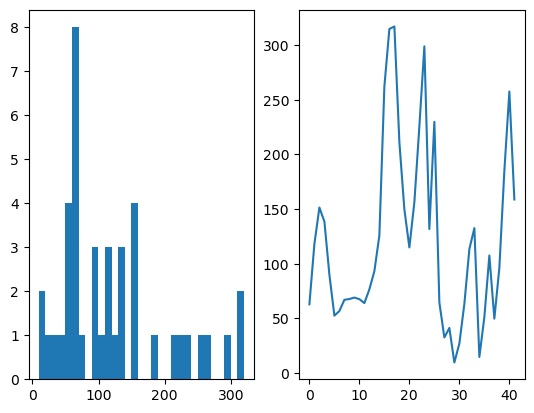

In [58]:
t=213984
f,(ax1,ax2)=plt.subplots(1,2)
ax1.hist(Aamplitude[t, :], bins=np.arange(min(Aamplitude[t, :]), max(Aamplitude[t, :]) + bin_size, bin_size))
ax2.plot(Aamplitude[t, :])

hist, bin_edges = np.histogram(Aamplitude[t, :], bins=np.arange(min(Aamplitude[t, :]), max(Aamplitude[t, :]) + bin_size, bin_size))
pmf = hist / np.sum(hist)
pmf = pmf[pmf > 0]
print(-np.sum(pmf * np.log2(pmf)))

In [59]:
alldata=np.copy(data4)
number_of_datapoints, number_of_channels = alldata.shape
    
# Filtering all the channels
Aamplitude = np.empty((number_of_datapoints, number_of_channels))
for i in range(number_of_channels):
    Aamplitude[:, i] = np.abs(hilbert(alldata[:, i]))

en = np.empty(number_of_datapoints)

# Calculating Entropies across channels
for t in range(number_of_datapoints):
    hist, bin_edges = np.histogram(Aamplitude[t, :], bins=np.arange(min(Aamplitude[t, :]), max(Aamplitude[t, :]) + bin_size, bin_size))
    pmf = hist / np.sum(hist)
    pmf = pmf[pmf > 0]
    en[t] = -np.sum(pmf * np.log2(pmf))
print(en[ss])

[4.00506355 3.96673878 3.85352717 3.91281824 4.44530701 4.15721497
 4.07995039 4.49292605 3.84722568 4.32971765]


4.0050635535766075


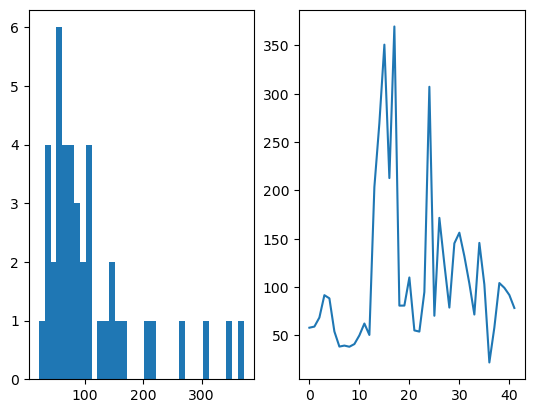

In [60]:
t=213984
f,(ax1,ax2)=plt.subplots(1,2)
ax1.hist(Aamplitude[t, :], bins=np.arange(min(Aamplitude[t, :]), max(Aamplitude[t, :]) + bin_size, bin_size))
ax2.plot(Aamplitude[t, :])

hist, bin_edges = np.histogram(Aamplitude[t, :], bins=np.arange(min(Aamplitude[t, :]), max(Aamplitude[t, :]) + bin_size, bin_size))
pmf = hist / np.sum(hist)
pmf = pmf[pmf > 0]
print(-np.sum(pmf * np.log2(pmf)))

In [62]:

4.005063553576608 - 4.0050635535766075

8.881784197001252e-16